In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import glob
import re
from pyproj import CRS, Transformer
import os
import matplotlib.colors as mcolors

In [2]:
folder_paths = ['/cluster/home/maikents/satellite_data/MODISA_L3m_CHL_R2022.0-20250317_094824', '/cluster/home/maikents/satellite_data/MODISA_L3m_CHL_R2022.0-20250317_104942', '/cluster/home/maikents/satellite_data/MODISA_L3m_CHL_R2022.0-20250317_102335']

chlor_a_data_list = []

for folder_path in folder_paths:
    print("new folder")
    nc_files = [f for f in os.listdir(folder_path) if f.endswith('.nc')]
    for file_name in nc_files:
        file_path = os.path.join(folder_path, file_name)
        
        dataset = xr.open_dataset(file_path)

        chlor_a_data_list.append(dataset['chlor_a'])

        dataset.close()

print("went through all files")

new folder
new folder
new folder
went through all files


In [12]:
chunk_size = 20 

concatenated_chlor_a = None

for i in range(0, len(chlor_a_data_list), chunk_size):
    chunk = chlor_a_data_list[i:i+chunk_size]
    chunk_concat = xr.concat(chunk, dim='time')
    
    if concatenated_chlor_a is None:
        concatenated_chlor_a = chunk_concat
    else:
        concatenated_chlor_a = xr.concat([concatenated_chlor_a, chunk_concat], dim='time')




Processed chunk 1 of 18
Processed chunk 2 of 18
Processed chunk 3 of 18
Processed chunk 4 of 18
Processed chunk 5 of 18
Processed chunk 6 of 18
Processed chunk 7 of 18
Processed chunk 8 of 18
Processed chunk 9 of 18
Processed chunk 10 of 18
Processed chunk 11 of 18
Processed chunk 12 of 18
Processed chunk 13 of 18
Processed chunk 14 of 18
Processed chunk 15 of 18
Processed chunk 16 of 18
Processed chunk 17 of 18
Processed chunk 18 of 18


In [13]:
output_file1 = '/cluster/home/maikents/satellite_data/chunks/chlor3.nc'
concatenated_chlor_a.to_netcdf(output_file1)

In [5]:
import xarray as xr

file_paths = [
    '/cluster/home/maikents/satellite_data/chunks/chlor1.nc',
    '/cluster/home/maikents/satellite_data/chunks/chlor2.nc',
    '/cluster/home/maikents/satellite_data/chunks/chlor3.nc'
]

concatenated_chlor_a = xr.open_mfdataset(file_paths, combine='nested', concat_dim='time')

print(concatenated_chlor_a)

<xarray.Dataset> Size: 161GB
Dimensions:  (time: 1081, lat: 4320, lon: 8640)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, lat, lon) float32 161GB dask.array<chunksize=(23, 288, 576), meta=np.ndarray>


In [6]:
#Remove points outside our study area
#Dimensions of our midnor study area:
lat_min = 59.996
lat_max = 67.961
lon_min = -1.901
lon_max = 15.061

lats = concatenated_chlor_a['lat']
lons = concatenated_chlor_a['lon']

lat_mask = (lats >= lat_min) & (lats <= lat_max)
lon_mask = (lons >= lon_min) & (lons <= lon_max)

masked_chlor_a = concatenated_chlor_a.where(lat_mask & lon_mask, drop=True)

print(masked_chlor_a)

<xarray.Dataset> Size: 336MB
Dimensions:  (time: 1081, lat: 191, lon: 407)
Coordinates:
  * lat      (lat) float32 764B 67.94 67.9 67.85 67.81 ... 60.1 60.06 60.02
  * lon      (lon) float32 2kB -1.896 -1.854 -1.812 -1.771 ... 14.94 14.98 15.02
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, lat, lon) float32 336MB dask.array<chunksize=(23, 191, 407), meta=np.ndarray>


In [24]:
masked_chlor_a.to_netcdf('/cluster/home/maikents/satellite_data/masked_chlor_a.nc')

In [ ]:
masked_chlor_a.to_netcdf('/cluster/home/maikents/satellite_data/masked_chlor_a.nc')

In [2]:
masked_chlor_a = xr.open_dataset('/cluster/home/maikents/satellite_data/masked_chlor_a.nc')

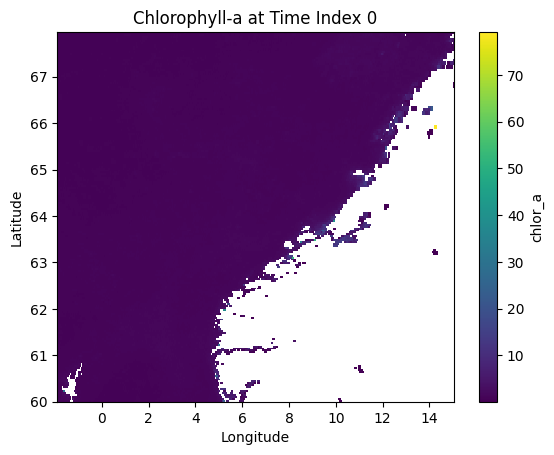

In [10]:
import matplotlib.pyplot as plt

# Plot the 'chlor_a' variable across the lat-lon grid (average over time if needed)
masked_chlor_a['chlor_a'].mean(dim="time").plot()  # Change 'time=0' to select specific time step or average over time
plt.title('Chlorophyll-a at Time Index 0')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

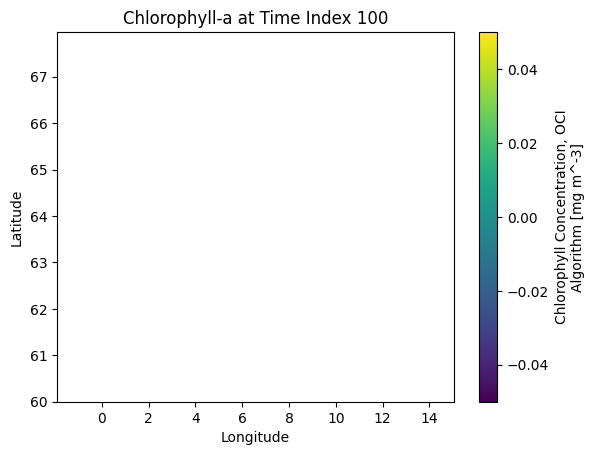

In [11]:
masked_chlor_a['chlor_a'].isel(time=55).plot()  # Change 'time=0' to select specific time step or average over time
plt.title('Chlorophyll-a at Time Index 100')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
print(masked_chlor_a)

<xarray.Dataset> Size: 336MB
Dimensions:  (time: 1081, lat: 191, lon: 407)
Coordinates:
  * lat      (lat) float32 764B 67.94 67.9 67.85 67.81 ... 60.1 60.06 60.02
  * lon      (lon) float32 2kB -1.896 -1.854 -1.812 -1.771 ... 14.94 14.98 15.02
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, lat, lon) float32 336MB ...


In [9]:
chlor_a_data = masked_chlor_a['chlor_a'][:,:,:].values

num_nans = np.sum(np.isnan(chlor_a_data))

num_non_nans = np.sum(~np.isnan(chlor_a_data))

print(f"Number of NaN values: {num_nans}")
print(f"Number of non-NaN values: {num_non_nans}")


Number of NaN values: 76355909
Number of non-NaN values: 7677788


Transform chlor data to EMOD grid

In [10]:
#Load the original SINMOD data from SINMOD grid

filename_SINMOD_original_grid = "/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc"

sinmod_data = Dataset(filename_SINMOD_original_grid, 'r')

In [11]:

def obtain_sinmod_crs(sinmod_data):
    
    grid_mapping = sinmod_data.variables['grid_mapping']

    horizontal_resolution = grid_mapping.getncattr('horizontal_resolution')

    print(f"Horizontal resolution: {horizontal_resolution} meters")

    crs_sinmod = CRS.from_proj4(f"+proj=stere "
                                f"+lat_0={grid_mapping.latitude_of_projection_origin} "
                                f"+lat_ts={grid_mapping.standard_parallel} "
                                f"+lon_0={grid_mapping.straight_vertical_longitude_from_pole} "
                                f"+x_0={grid_mapping.false_easting} "
                                f"+y_0={grid_mapping.false_northing} "
                                f"+a={grid_mapping.semi_major_axis} "
                                f"+b={grid_mapping.semi_minor_axis} "
                                f"+units=m +no_defs")
    return crs_sinmod


crs_sinmod = obtain_sinmod_crs(sinmod_data)

Horizontal resolution: 800.0 meters


In [37]:
#Next, transform all satellite data to SINMOD grid coordinates

def transform_chlorophyll_coordinates(chlor_data, crs_sinmod):
    
    #Define the crs for the satellite data
    crs_wgs84 = CRS.from_epsg(4326)  #WGS84 (lat/lon coordinates)

    transformer_wgs84_to_sinmod = Transformer.from_crs(crs_wgs84, crs_sinmod, always_xy=True)
    
    lat = chlor_data['lat'].values
    lon = chlor_data['lon'].values

    lon_grid, lat_grid = np.meshgrid(lon, lat)

    lon_flat = lon_grid.flatten()
    lat_flat = lat_grid.flatten()


    #Transform satellite coordinates from WGS84 to SINMOD
    chlor_x_flat, chlor_y_flat = transformer_wgs84_to_sinmod.transform(lon_flat, lat_flat)

    #Reshape the transformed coordinates back to the original grid shape
    chlor_x = chlor_x_flat.reshape(lat.shape[0], lon.shape[0])
    chlor_y = chlor_y_flat.reshape(lat.shape[0], lon.shape[0])
    
    x_array = xr.DataArray(chlor_x, dims=['lat', 'lon'], coords={'lat': chlor_data['lat'], 'lon': chlor_data['lon']})
    y_array = xr.DataArray(chlor_y, dims=['lat', 'lon'], coords={'lat': chlor_data['lat'], 'lon': chlor_data['lon']})

    #Add x and y as new coordinates to the dataset
    chlor_data = chlor_data.assign_coords(x=x_array, y=y_array)

    return chlor_data


transformed_chlor_data = transform_chlorophyll_coordinates(masked_chlor_a, crs_sinmod)

output_directory = '/cluster/home/maikents/features_midnor_2019/'
output_file = 'midnor_chlorophyll_sinmod_grid.parquet'


#Save the file
transformed_chlor_data.to_netcdf('/cluster/home/maikents/features_midnor_2019/midnor_chlorophyll_sinmod_grid.nc')


In [13]:
transformed_chlor_data = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/midnor_chlorophyll_sinmod_grid.nc')

In [20]:
#Next, transform all satellite data to EMOD grid coordinates

import pandas as pd
from pyproj import CRS, Transformer

crs_target = CRS.from_epsg(32632)

def transform_chlorophyll_coordinates(chlor_data, crs_target, crs_source):
    
    chlor_data = chlor_data.copy()
    
    transformer_crs_to_target = Transformer.from_crs(crs_source, crs_target, always_xy=True)
    
    old_x = chlor_data['x'].values
    old_y = chlor_data['y'].values
    
    lat = chlor_data['lat'].values
    lon = chlor_data['lon'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    
    lon_flat = lon_grid.flatten()
    lat_flat = lat_grid.flatten()

    chlor_x_flat, chlor_y_flat = transformer_crs_to_target.transform(lon_flat, lat_flat)

    chlor_x = chlor_x_flat.reshape(lat_grid.shape)
    chlor_y = chlor_y_flat.reshape(lat_grid.shape)
    
    #chlor_data['x'] = (['lat', 'lon'], chlor_x)
    #chlor_data['y'] = (['lat', 'lon'], chlor_y)
    chlor_data['lon'] = (['lat', 'lon'], chlor_x)
    chlor_data['lat'] = (['lat', 'lon'], chlor_y)
    chlor_data = chlor_data.drop_vars(['x', 'y'])
    chlor_data = chlor_data.rename({'lon': 'x', 'lat': 'y'})




    return chlor_data

transformed_chlor_data_emod = transform_chlorophyll_coordinates(transformed_chlor_data, crs_target, crs_sinmod)

In [7]:
sinmod = xr.open_dataset('/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/ready-for-training/SINMOD_bottom_features.nc')

In [21]:
print(transformed_chlor_data_emod )

<xarray.Dataset> Size: 337MB
Dimensions:  (time: 1081, y: 191, x: 407)
Coordinates:
    y        (y, x) float64 622kB 6.656e+06 6.656e+06 ... 6.656e+06 6.656e+06
    x        (y, x) float64 622kB 2.777e+05 2.777e+05 ... 2.777e+05 2.777e+05
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, y, x) float32 336MB ...


In [22]:
transformed_chlor_data_emod.to_netcdf('/cluster/home/maikents/features_midnor_2019/midnor_chlorophyll_emod_grid.nc')

In [23]:
chlor_a_data = transformed_chlor_data_emod['chlor_a'][:,:,:].values

num_nans = np.sum(np.isnan(chlor_a_data))

num_non_nans = np.sum(~np.isnan(chlor_a_data))

print(f"Number of NaN values: {num_nans}")
print(f"Number of non-NaN values: {num_non_nans}")


Number of NaN values: 76355909
Number of non-NaN values: 7677788


In [24]:
#Standardizing
from sklearn.preprocessing import StandardScaler

chlor_a_values = transformed_chlor_data_emod['chlor_a'].values  

num_time = chlor_a_values.shape[0]
num_y = chlor_a_values.shape[1]
num_x = chlor_a_values.shape[2]

flattened_chlor_a = chlor_a_values.reshape(-1, 1)

scaler = StandardScaler()
standardized_chlor_a = scaler.fit_transform(flattened_chlor_a)

standardized_chlor_a_reshaped = standardized_chlor_a.reshape(num_time, num_y, num_x)

transformed_chlor_data_emod['chlor_a_standardized'] = (('time', 'y', 'x'), standardized_chlor_a_reshaped)

print(transformed_chlor_data_emod)

<xarray.Dataset> Size: 674MB
Dimensions:               (time: 1081, y: 191, x: 407)
Coordinates:
    y                     (y, x) float64 622kB 6.656e+06 6.656e+06 ... 6.656e+06
    x                     (y, x) float64 622kB 2.777e+05 2.777e+05 ... 2.777e+05
Dimensions without coordinates: time
Data variables:
    chlor_a               (time, y, x) float32 336MB nan nan nan ... nan nan nan
    chlor_a_standardized  (time, y, x) float32 336MB nan nan nan ... nan nan nan


In [25]:
transformed_chlor_data_emod.to_netcdf('/cluster/home/maikents/features_midnor_2019/midnor_chlorophyll_emod_grid_standardized.nc')

In [26]:
chlor_a_data = transformed_chlor_data_emod['chlor_a'][:,:,:].values

num_nans = np.sum(np.isnan(chlor_a_data))

num_non_nans = np.sum(~np.isnan(chlor_a_data))

print(f"Number of NaN values: {num_nans}")
print(f"Number of non-NaN values: {num_non_nans}")


Number of NaN values: 76355909
Number of non-NaN values: 7677788
